<a href="https://colab.research.google.com/github/dhnanjay/HuggingFace/blob/main/Hacker_News_TLDR_with_Haystack2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Hacker News Top Stories TL;DR

*by Tuana Celik: [Twitter](https://twitter.com/tuanacelik), [LinkedIn](https://www.linkedin.com/in/tuanacelik/)*

📚 Check out the [**Customizing RAG Pipelines to Summarize Latest Hacker News Posts with Haystack 2.0 Preview**](https://haystack.deepset.ai/blog/customizing-rag-to-summarize-hacker-news-posts-with-haystack2?utm_campaign=developer-relations&utm_source=hackernews-livestream&utm_medium=colab) article for a detailed run through a similar example to this notebook.

You can also try this in the live [🤗 Hacker News TLDR Hugging Face Space](https://huggingface.co/spaces/Tuana/hackernews-summaries)
> 🎉 This Colab uses the newly released Haystack 2.0
>
> To learn more 👇
>
> [💜 **Haystack 2.0 Migration Guide**](https://docs.haystack.deepset.ai/docs/migration?utm_campaign=developer-relations&utm_source=hackernews-livestream&utm_medium=colab)
>
> [📄 **Documentation**](https://docs.haystack.deepset.ai?utm_campaign=developer-relations&utm_source=hackernews-livestream&utm_medium=colab)
>
> [📚 **Tutorials**](https://haystack.deepset.ai/tutorials?utm_campaign=developer-relations&utm_source=hackernews-livestream&utm_medium=colab)

###Install dependencies

In [ ]:
!pip install newspaper3k haystack-ai==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13538 sha256=312a934eeab7ae7e212577d32cf3938359220a100b830b502ac195dcbbfb28d1
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3340 sha256=5343c23617f31b312af05d9fb1b068e51799fd93ec35a09e4ac4e451572ee1ec
  Stored in directory: /root/.cache/pip/wheels/97/02/e7/a1ff1760e12bdbaab0ac824fae5c1bc

## Create a Custom Haystack 2.0 Component

This `HackernewsFetcher` ferches the `top_k` newest posts on Hacker News and returns the contents as a List of Haystack Document objects

In [ ]:
from typing import List
from haystack import component, Document
from newspaper import Article
import requests

@component
class HackernewsFetcher():

  @component.output_types(articles=List[Document])
  def run(self, top_k: int):
    top_list = requests.get(url='https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty')
    articles = []
    for id in top_list.json()[0:top_k]:
      article = requests.get(url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty")
      if 'url' in article.json():
        articles.append(article.json()['url'])

    docs = []
    for url in articles:
      try:
        article = Article(url)
        article.download()
        article.parse()
        docs.append(Document(content=article.text, meta={'title': article.title, 'url': url}))
      except:
        print(f"Couldn't download {url}, skipped")
    return {'articles': docs}




## Create a Haystack 2.0 RAG Pipeline

The end result is a RAG pipeline designed to provide a list of summaries for each of the `top_k` posts on Hacker News, followes by the source URL. We're goint to be using the [`HuggingFaceTGIGenerator`](https://docs.haystack.deepset.ai/v2.0/docs/huggingfacetgigenerator?utm_campaign=developer-relations&utm_source=fosdem&utm_medium=colab), so first, you should provide your Hugging Face token below 👇

In [ ]:
import os
from getpass import getpass

os.environ["HF_API_TOKEN"] = getpass("HuggingFace Token:")

HuggingFace Token:··········


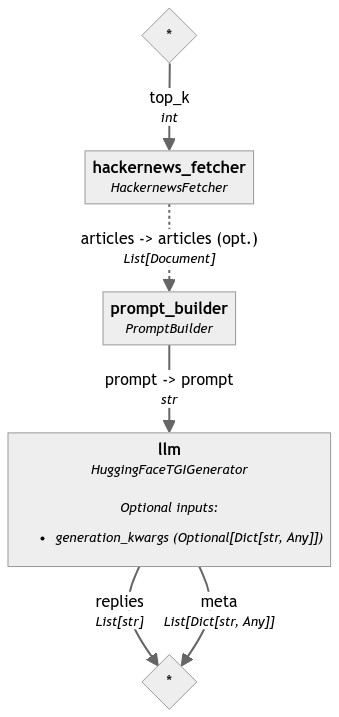

In [ ]:
from haystack import Pipeline
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import HuggingFaceTGIGenerator

prompt_template = """
You will be provided one or more top HakcerNews posts, followed by their URL.
For each post you have, provide a short summary followed by the URL that the post can be found at.

Posts:
{% for article in articles %}
  Post content: {{article.content}}
  Post URL: {{article.meta['url']}}
{% endfor %}
Summaries:
"""

prompt_builder = PromptBuilder(template=prompt_template)
llm = HuggingFaceTGIGenerator("mistralai/Mistral-7B-Instruct-v0.2")
fetcher = HackernewsFetcher()

pipe = Pipeline()
pipe.add_component("hackernews_fetcher", fetcher)
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("llm", llm)

pipe.connect("hackernews_fetcher.articles", "prompt_builder.articles")
pipe.connect("prompt_builder.prompt", "llm.prompt")

In [ ]:
result = pipe.run(data={"hackernews_fetcher": {"top_k": 3},
                        "llm": {"generation_kwargs": {"max_new_tokens": 600}}
                       })
print(result['llm']['replies'][0])

 In this post, the author measures the input latency of various terminal emulators, including Alacritty, Console, VTE Test App, and GNOME Terminal, using a hardware input latency tester. The tests were conducted on a Lenovo Legion 7 Gen 7 AMD laptop with Fedora 40 Silverblue Beta and raw Mutter compositor. The first test involved measuring the time it takes for the terminal to move its block cursor one cell to the right after pressing Space in a simple cat > /dev/null scenario. The second test involved opening a snapshot of the author's neovim setup and repeatedly pressing Ctrl+D and Ctrl+U to scroll the text buffer down and up in neovim, which provided a more realistic case. The results showed significant improvements in input latency for all VTE terminals, bringing them almost on par with Alacritty. The author attributes the improvements to a change in VTE that moves away from a 40 Hz VTE repaint timer to drawing every frame, synchronized with the monitor. The author also ran Alacrit